In [5]:
import pandas as pd
import numpy as np
import copy

import seaborn as sns
from matplotlib.pyplot import plot as plt
import collections

import random

import optuna

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from patsy import dmatrices

import matplotlib.pyplot as plt

import iml_od_preprocessing
import iml_od_modelling

import binary_classification

In [14]:
df = pd.read_csv('./Data/processed_CAR_data.csv')

df = df.drop(['Unnamed: 0', 'ProductName', 'FullTitle', 
              'ProtocolStatus', 'PlannedPrimaryStudy_CompletionDate', 
              'ActualPrimaryStudy_CompletionDate', 'SynopsisActualDate',
              'Protocol_ActualDate', 'FirstSiteActivated_ActualDate', 
              'FSS_ActualDate', 'FSI_ActualDate', 'FSFV_ActualDate', 
              'LSI_ActualDate', 'LSI_AvgTx_ActualDate', 
              'LSO_2_ActualDate', 'LSO_3_ActualDate', 'LSO_4_ActualDate', 
              'LSO_Final_ActualDate', 'DBL_2_ActualDate', 
              'DBL_3_ActualDate', 'DBL_4_ActualDate', 'DBL_Final_ActualDate'], axis = 1)

df = df.drop(['ActualScreened', 'ActualRescreened', 
              'ActualScreenFailure', 'LegacyCompany'], axis = 1)

df = df.drop(['Protocol_to_FirstSiteActivated', 
              'FirstSiteActivated_to_FSS', 'FSI_to_FSFV', 
              'LSI_to_LSIAvgTxL', 'FSFV_to_LSI'], axis = 1)

df = df[df.CloseOut>=0]

# df = df.drop(['LSO','DBL'], axis = 1)

df_matching = pd.read_csv('./Data/trial_ids_car_data.csv')

df_errors = pd.read_excel('./Data/DM_RT_DATA_INGEST_AUTOMATN_LOGS_PROCESSING.xlsx')

df_errors = df_errors[['STUDY_CODE', 'STUDY_ERROR_STATUS', 
                       'ERROR_STATUS', 'MISSING_DOMAIN', 
                       'DASHBOARD_IMPACT']]

df_errors = df_errors[['STUDY_CODE','MISSING_DOMAIN']].drop_duplicates()

df_errors = iml_od_preprocessing.one_hot_encoding_one_column(df_errors, 'MISSING_DOMAIN')

df_errors = df_errors.groupby('STUDY_CODE').sum().reset_index()



df_trial_ids_errors = df_matching.merge(df_errors)

df_trial_ids_errors = df_trial_ids_errors.rename(columns = {"MATCHED_TRIAL_ID": "ProtocolNum"})

df_trials = df[['ProtocolNum']]

df_trial_ids_errors = df_trials.merge(df_trial_ids_errors, how = 'left')

df_trial_ids_errors = df_trial_ids_errors.fillna(0.0)

df_trial_ids_errors = df_trial_ids_errors.drop(['STUDY_CODE'], axis = 1)

df = df.merge(df_trial_ids_errors, how = 'left')

df_unlock_dates = pd.read_csv('./Data/max_dates_unlocks.csv')

df_unlock_dates = df_unlock_dates.groupby(['ProtocolNum']).agg({
    'Lock_duration':'sum','Unlocks_max_date':'max'}).reset_index()

###

df = df.merge(df_unlock_dates, how = 'left')

df['Unlocks_max_date'] = df['Unlocks_max_date'].fillna('1900-01-01')

df["DBL_ActualDate_new"] = df[["DBL_ActualDate", "Unlocks_max_date"]].max(axis=1)

df["DBL_ActualDate"] = df['DBL_ActualDate_new']

df = df.drop(['DBL_ActualDate_new'], axis = 1)

df['LSO_ActualDate'] = pd.to_datetime(df['LSO_ActualDate'])

df['DBL_ActualDate'] = pd.to_datetime(df['DBL_ActualDate'])

df['CloseOut_new'] = (df['DBL_ActualDate'] - df['LSO_ActualDate']).dt.days

df = df.drop(['Unlocks_max_date'], axis = 1)

df['Lock_duration'] = df['Lock_duration'].fillna(0.0)

###

###PREVIOUS CLOSE OUT

df = df.drop(['CloseOut'], axis = 1)

###

df_expected_lso_dbl = pd.read_csv('./Data/expected_lso_dbl.csv')

df_car_msps_trial_id_matching = pd.read_csv('./Data/expected_lso_dbl_trial_id_matching.csv')

df = df.merge(df_car_msps_trial_id_matching, how = 'left')

df = df.merge(df_expected_lso_dbl, how='left')

df = df.drop(['Trial_ID_CAR','InterACT_Trial_ID', 'Expected_LSO'], axis = 1)

df['Ontime'] = (pd.to_datetime(df.DBL_ActualDate)-pd.to_datetime(df.Expected_DBL)).dt.days<5

df['Ontime'] = df['Ontime']*1

df = df.drop(['Expected_DBL'], axis = 1)

### Unlocks feature

unlocks = {}
unlocks['TAK-954-1007'] = 3
unlocks['Pevonedistat-1014'] = 3
unlocks['C34005'] = 3
unlocks['MLN0002-2003'] = 1
unlocks['AP26113-13-301'] = 1
unlocks['Pevonedistat-1012'] = 1
unlocks['DEN-315'] = 1
unlocks['DEN-314'] = 1
unlocks['Pevonedistat-2001'] = 1
unlocks['AP26113-11-101'] = 1
unlocks['TAK-438_305'] = 1
unlocks['MLN0002SC-3031'] = 1
unlocks['DEN-204'] = 1
unlocks['Pevonedistat-1015'] = 1
unlocks['TAK-041-2001'] = 1
unlocks['C34007'] = 1
unlocks['TAK-418-0004'] = 1
unlocks['TAK-925-1009'] = 2
unlocks['TAK-925-1013'] = 1
unlocks['TAK-925-2001'] = 1
unlocks['Vedolizumab-1019'] = 2
unlocks['TAK-954-2003'] = 1
unlocks['TAK-994-1001'] = 1
unlocks['TIMP-GLIA-5001'] = 2
unlocks['SHP634-402'] = 1
unlocks['DEN-307'] = 1
unlocks['Brigatinib-2002'] = 3
unlocks['TAK-951-1001'] = 1
unlocks['TAK-994-1503'] = 1
unlocks['TAK-831-2002'] = 1
unlocks['TAK-935-2004'] = 1

unlocks_column = []

for prot in df.ProtocolNum.to_list():
    
    try:
        cur_unlocks = unlocks[prot]
    except:
        cur_unlocks = 0
    
    unlocks_column.append(cur_unlocks)
    
df['Unlocks'] = unlocks_column

df = df.drop(['CloseOut_new'], axis = 1)

df

,ProtocolNum,ProtocolPhase,TA,PlannedEnrollment,ActualEnrollment,ActualRandomizedDosed,ActualEarlyTerminated,PercEnrollmentCompleted,PlannedSites,ActiveSites,...,FA,LB,MH,PR,SS,VS,Lock_duration,Expected_CloseOut,Ontime,Unlocks
0,TAK-071-1002,I,NS,46,18,0,12,39.13%,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.0,1,0
1,C16014 Korea Continuation,III,Oncology,40,41,0,8,102.50%,11,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,1,0
2,C34007,I,Oncology,22,17,11,0,77.27%,5,0,...,0.0,0.0,0.0,0.0,1.0,0.0,8.0,28.0,0,1
3,TAK-438_115,I,GI,30,30,0,0,100.00%,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1,0
4,TAK-438_302,III,GI,830,236,1,0,28.43%,68,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,NOR-202,II,NonCore,840,840,840,0,100.00%,12,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.0,1,0
308,NOR-204,II,NonCore,325,320,0,11,98.46%,10,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0,1,0
309,NOR-210,II,NonCore,50,50,0,2,100.00%,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0
310,NOR-211,II,NonCore,"4,176","4,758",0,0,113.94%,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1,0


In [15]:
# df = df[df['DBL_ActualDate'].astype(str).str.contains('2019|2020|2021')]

# df

In [16]:
sum(df.Ontime)

180

In [68]:
df.columns

Index(['ProtocolNum', 'ProtocolPhase', 'TA', 'PlannedEnrollment',
       'ActualEnrollment', 'ActualRandomizedDosed', 'ActualEarlyTerminated',
       'PercEnrollmentCompleted', 'PlannedSites', 'ActiveSites', 'CRO',
       'LSO_ActualDate', 'DBL_ActualDate', 'numValsLSO', 'numValsDBL',
       'PrimaryStudy_to_Synopsis', 'Synopsis_to_Protocol', 'FSS_to_FSI',
       'LSI_to_LSO', 'AE', 'CM', 'DS', 'DV', 'EG', 'EX', 'FA', 'LB', 'MH',
       'PR', 'SS', 'VS', 'Lock_duration', 'Expected_CloseOut', 'Ontime',
       'Unlocks'],
      dtype='object')

In [69]:

df['PlannedEnrollment'] = df['PlannedEnrollment'].str.replace(',','.')
df['PlannedEnrollment'] = pd.to_numeric(df['PlannedEnrollment'])

df['ActualEnrollment'] = df['ActualEnrollment'].str.replace(',','.')
df['ActualEnrollment'] = pd.to_numeric(df['ActualEnrollment'])

df['PercActualCompetedTrial'] = (df['ActualEnrollment'] - df['ActualEarlyTerminated'])*100/df['ActualEnrollment']

df['PercEnrollmentCompleted'] = df['PercEnrollmentCompleted'].map(lambda x: str(x)[:-1])
df['PercEnrollmentCompleted'] = pd.to_numeric(df['PercEnrollmentCompleted'])

df = iml_od_preprocessing.CRO_preprocessing(df)

df = df.drop(['ProtocolNum'], axis = 1)
df = df.drop(['LSO_ActualDate'], axis = 1)

cb_df = copy.deepcopy(df) # Creating df for catBoost with cat variables not encoded

#df = iml_od_preprocessing.one_hot_encoding_one_column(df, 'CRO')
df = iml_od_preprocessing.one_hot_encoding_one_column(df, 'ProtocolPhase')
df = iml_od_preprocessing.one_hot_encoding_one_column(df, 'TA')


In [70]:
df.shape

(313, 46)

In [7]:
# df = df.drop(['ProtocolNum'], axis = 1)
# df = df.drop(['LSO_ActualDate'], axis = 1)

df.dtypes

PlannedEnrollment                  float64
ActualEnrollment                   float64
ActualRandomizedDosed              float64
ActualEarlyTerminated              float64
PercEnrollmentCompleted            float64
PlannedSites                       float64
ActiveSites                        float64
DBL_ActualDate              datetime64[ns]
numValsLSO                           int64
numValsDBL                           int64
PrimaryStudy_to_Synopsis           float64
Synopsis_to_Protocol               float64
FSS_to_FSI                         float64
LSI_to_LSO                         float64
AE                                 float64
CM                                 float64
DS                                 float64
DV                                 float64
EG                                 float64
EX                                 float64
FA                                 float64
LB                                 float64
MH                                 float64
PR         

In [71]:
# Date Boundaries 
DATE_BOUND_TRAIN = '2019-03-15' # Lower bound of validation set
DATE_BOUND_EVAL = '2020-07-15' # Upper bound of validation set (lower of testing set)

# DATE_BOUND_TRAIN = '2020-09-15'
# DATE_BOUND_EVAL = '2021-01-01'
DATE_BOUND_TEST = '2022-02-15' # Upper bound of testing set 

In [72]:
train_X, eval_X, trval_X, test_X, train_y, eval_y, trval_y, test_y = binary_classification.split_data(df, 
                                                                                DATE_BOUND_TRAIN = DATE_BOUND_TRAIN, 
                                                                                DATE_BOUND_EVAL = DATE_BOUND_EVAL,
                                                                                DATE_BOUND_TEST = DATE_BOUND_TEST)

In [74]:
print(train_X.shape, eval_X.shape, test_X.shape)

(182, 44) (73, 44) (58, 44)


In [13]:
n_trials = 10

train_X, eval_X, trval_X, test_X, train_y, eval_y, trval_y, test_y = binary_classification.split_data(df, 
                                                                                DATE_BOUND_TRAIN = DATE_BOUND_TRAIN, 
                                                                                DATE_BOUND_EVAL = DATE_BOUND_EVAL,
                                                                                DATE_BOUND_TEST = DATE_BOUND_TEST)

ordinal_features = train_X.columns
ordinal_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
        [('ord', ordinal_transformer, ordinal_features)]
)

train_X = preprocessor.fit_transform(train_X)
trval_X = preprocessor.transform(trval_X)
eval_X = preprocessor.transform(eval_X)
test_X = preprocessor.transform(test_X)





# First section is for numeric categories, second section is for actual labels
logreg_results = binary_classification.logistic_model(train_X, eval_X, trval_X, test_X, 
                                                      train_y, eval_y, trval_y, test_y, 
                                                      n_trials)
df_logreg = pd.DataFrame(logreg_results, index = [0])


dt_results = binary_classification.decision_tree(train_X, eval_X, trval_X, test_X, 
                                                 train_y, eval_y, trval_y, test_y, 
                                                 n_trials)
df_dt = pd.DataFrame(dt_results, index = [1])


rf_results = binary_classification.rf_model(train_X, eval_X, trval_X, test_X, 
                                            train_y, eval_y, trval_y, test_y, 
                                            n_trials)
df_rf = pd.DataFrame(rf_results, index = [2])


xgb_results = binary_classification.xgb_model(train_X, eval_X, trval_X, test_X, 
                                              train_y, eval_y, trval_y, test_y, 
                                              n_trials)
df_xgb = pd.DataFrame(xgb_results, index = [3])


#######################
cat_cols = ['ProtocolPhase', 'TA']
cat_feat_idxs = binary_classification.get_cat_idx(cb_df, cat_cols)
train_X, eval_X, trval_X, test_X, train_y, eval_y, trval_y, test_y = binary_classification.split_data(cb_df, 
                                                                                DATE_BOUND_TRAIN = DATE_BOUND_TRAIN, 
                                                                                DATE_BOUND_EVAL = DATE_BOUND_EVAL,
                                                                                DATE_BOUND_TEST = DATE_BOUND_TEST)

cb_results = binary_classification.cb_model(train_X, eval_X, trval_X, test_X, 
                                            train_y, eval_y, trval_y, test_y, 
                                            n_trials = n_trials, cat_feat_idxs = cat_feat_idxs)
df_cb = pd.DataFrame(cb_results, index = [4])

results_concat = pd.concat([df_logreg, 
                            df_dt, 
                            df_rf, 
                            df_xgb,
                            df_cb
                           ])

[I 2021-08-11 20:46:01,717] A new study created in memory with name: no-name-d3734a18-6dc1-4068-9196-9d11d15fe57e
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
[I 2021-08-11 20:47:08,916] Trial 0 finished with value: 0.731608005521049 and parameters: {'penalty': 'l1', 'C': 41.7022004702574, 'multi_class': 'auto', 'solver': 'liblinear', 'max_iter': 10000}. Best is trial 0 with value: 0.731608005521049.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "

[I 2021-08-11 20:55:37,165] Trial 7 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 27, 'min_samples_leaf': 3, 'ccp_alpha': 4.268965487550016}. Best is trial 0 with value: 0.5.
[I 2021-08-11 20:55:37,177] Trial 8 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 15, 'ccp_alpha': 3.2236047469600235}. Best is trial 0 with value: 0.5.
[I 2021-08-11 20:55:37,190] Trial 9 finished with value: 0.5 and parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 26, 'min_samples_leaf': 2, 'ccp_alpha': 7.526428717955178}. Best is trial 0 with value: 0.5.


Time for preparing Logistic model result:  9.59  minutes


[I 2021-08-11 20:55:38,003] A new study created in memory with name: no-name-ac1f6575-f6a8-4e95-ac48-6b2e4803813c
[I 2021-08-11 20:55:38,082] Trial 0 finished with value: 0.800534851621808 and parameters: {'max_depth': 5, 'n_estimators': 15}. Best is trial 0 with value: 0.800534851621808.
[I 2021-08-11 20:55:38,129] Trial 1 finished with value: 0.709351276742581 and parameters: {'max_depth': 2, 'n_estimators': 8}. Best is trial 0 with value: 0.800534851621808.
[I 2021-08-11 20:55:38,159] Trial 2 finished with value: 0.6906659765355417 and parameters: {'max_depth': 3, 'n_estimators': 4}. Best is trial 0 with value: 0.800534851621808.


Time for preparing Decision Tree result:  0.02  minutes


[I 2021-08-11 20:55:38,210] Trial 3 finished with value: 0.7425810904071773 and parameters: {'max_depth': 3, 'n_estimators': 9}. Best is trial 0 with value: 0.800534851621808.
[I 2021-08-11 20:55:38,283] Trial 4 finished with value: 0.8385438233264321 and parameters: {'max_depth': 5, 'n_estimators': 12}. Best is trial 4 with value: 0.8385438233264321.
[I 2021-08-11 20:55:38,363] Trial 5 finished with value: 0.7433747412008281 and parameters: {'max_depth': 5, 'n_estimators': 15}. Best is trial 4 with value: 0.8385438233264321.
[I 2021-08-11 20:55:38,457] Trial 6 finished with value: 0.7118530020703933 and parameters: {'max_depth': 3, 'n_estimators': 18}. Best is trial 4 with value: 0.8385438233264321.
[I 2021-08-11 20:55:38,541] Trial 7 finished with value: 0.776432022084196 and parameters: {'max_depth': 2, 'n_estimators': 15}. Best is trial 4 with value: 0.8385438233264321.
[I 2021-08-11 20:55:38,615] Trial 8 finished with value: 0.7668046928916494 and parameters: {'max_depth': 5, 'n_e

Time for preparing Random Forest result:  0.03  minutes
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WAR

C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The u

[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The u

[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The u

[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-08-11 20:55:40,340] Trial 7 finished with value: 0.4899930986887509 and paramete

[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\wyk7050\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[I 2021-08-11 20:55:40,557] Trial 9 finished with value: 0.4627674258109041 and paramete

[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:55:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[I 2021-08-11 20:55:41,487] A new study created in memory with name: no-name-c3f7b85b-c62c-4718-a325-79f7df1d39ef


Time for preparing XGB result:  0.03  minutes
0:	test: 0.5506912	best: 0.5506912 (0)	total: 2.03ms	remaining: 5.08s


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


500:	test: 0.6397849	best: 0.6443932 (114)	total: 4s	remaining: 16s
1000:	test: 0.6397849	best: 0.6443932 (114)	total: 8.46s	remaining: 12.7s
1500:	test: 0.6420891	best: 0.6443932 (114)	total: 12.3s	remaining: 8.21s
2000:	test: 0.6420891	best: 0.6443932 (114)	total: 16.5s	remaining: 4.12s
2499:	test: 0.6459293	best: 0.6466974 (2327)	total: 21s	remaining: 0us

bestTest = 0.6466973886
bestIteration = 2327

Shrink model to first 2328 iterations.


[I 2021-08-11 20:56:03,524] Trial 0 finished with value: 0.6466973886328726 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.06838308065836035, 'depth': 12, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'loss_function': 'CrossEntropy', 'learning_rate': 1.0183410905645716, 'random_strength': 1.095151211346005, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC'}. Best is trial 0 with value: 0.6466973886328726.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	test: 0.5856375	best: 0.5856375 (0)	total: 12.4ms	remaining: 30.9s
500:	test: 0.6620584	best: 0.6797235 (20)	total: 7.15s	remaining: 28.5s
1000:	test: 0.6605223	best: 0.6797235 (20)	total: 14.3s	remaining: 21.4s
1500:	test: 0.6605223	best: 0.6797235 (20)	total: 21.5s	remaining: 14.3s
2000:	test: 0.6620584	best: 0.6797235 (20)	total: 28.9s	remaining: 7.21s


[I 2021-08-11 20:56:40,421] Trial 1 finished with value: 0.6797235023041475 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.08543434276046996, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'loss_function': 'CrossEntropy', 'learning_rate': 1.1259572035506904, 'random_strength': 1.3380347426686274, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC', 'bagging_temperature': 1.4038693859523377}. Best is trial 1 with value: 0.6797235023041475.


2499:	test: 0.6620584	best: 0.6797235 (20)	total: 36s	remaining: 0us

bestTest = 0.6797235023
bestIteration = 20

Shrink model to first 21 iterations.
0:	test: 0.5241935	best: 0.5241935 (0)	total: 3.06ms	remaining: 7.64s
500:	test: 0.6513057	best: 0.7465438 (7)	total: 2.35s	remaining: 9.4s
1000:	test: 0.6536098	best: 0.7465438 (7)	total: 4.57s	remaining: 6.84s
1500:	test: 0.6574501	best: 0.7465438 (7)	total: 7.46s	remaining: 4.97s
2000:	test: 0.6543779	best: 0.7465438 (7)	total: 10.6s	remaining: 2.65s


[I 2021-08-11 20:56:54,008] Trial 2 finished with value: 0.7465437788018433 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.03773420847188303, 'depth': 13, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'loss_function': 'CrossEntropy', 'learning_rate': 0.6275663170546668, 'random_strength': 0.5585821748493236, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC'}. Best is trial 2 with value: 0.7465437788018433.


2499:	test: 0.6551459	best: 0.7465438 (7)	total: 12.8s	remaining: 0us

bestTest = 0.7465437788
bestIteration = 7

Shrink model to first 8 iterations.
0:	test: 0.5046083	best: 0.5046083 (0)	total: 1.73ms	remaining: 4.33s
500:	test: 0.6758833	best: 0.6820276 (172)	total: 801ms	remaining: 3.2s
1000:	test: 0.6751152	best: 0.6820276 (172)	total: 1.51s	remaining: 2.27s
1500:	test: 0.6751152	best: 0.6820276 (172)	total: 2.24s	remaining: 1.49s
2000:	test: 0.6751152	best: 0.6820276 (172)	total: 3.01s	remaining: 751ms


[I 2021-08-11 20:56:58,551] Trial 3 finished with value: 0.6820276497695853 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.033776258739039645, 'depth': 14, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'loss_function': 'CrossEntropy', 'learning_rate': 0.9732734465090944, 'random_strength': 1.5297513915223755, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC', 'bagging_temperature': 8.346256718973729}. Best is trial 2 with value: 0.7465437788018433.


2499:	test: 0.6751152	best: 0.6820276 (172)	total: 3.88s	remaining: 0us

bestTest = 0.6820276498
bestIteration = 172

Shrink model to first 173 iterations.
0:	test: 0.5000000	best: 0.5000000 (0)	total: 2.27ms	remaining: 5.67s


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


500:	test: 0.7227343	best: 0.7403994 (443)	total: 1.36s	remaining: 5.44s
1000:	test: 0.7388633	best: 0.7542243 (693)	total: 2.69s	remaining: 4.03s
1500:	test: 0.7250384	best: 0.7542243 (693)	total: 4.07s	remaining: 2.71s
2000:	test: 0.7227343	best: 0.7542243 (693)	total: 5.52s	remaining: 1.38s


[I 2021-08-11 20:57:06,207] Trial 4 finished with value: 0.7542242703533026 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.012560358828186853, 'depth': 12, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'CrossEntropy', 'learning_rate': 1.1718402892638577, 'random_strength': 1.8628932546396433, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC', 'subsample': 0.3642527335363116}. Best is trial 4 with value: 0.7542242703533026.


2499:	test: 0.7250384	best: 0.7542243 (693)	total: 6.83s	remaining: 0us

bestTest = 0.7542242704
bestIteration = 693

Shrink model to first 694 iterations.
0:	test: 0.4335637	best: 0.4335637 (0)	total: 1.15ms	remaining: 2.88s
500:	test: 0.7480799	best: 0.7572965 (87)	total: 1.04s	remaining: 4.17s
1000:	test: 0.7442396	best: 0.7572965 (87)	total: 2.08s	remaining: 3.12s
1500:	test: 0.7427035	best: 0.7572965 (87)	total: 3.21s	remaining: 2.13s
2000:	test: 0.7419355	best: 0.7572965 (87)	total: 4.2s	remaining: 1.05s


[I 2021-08-11 20:57:12,090] Trial 5 finished with value: 0.7572964669738863 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.05028854740208882, 'depth': 4, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'loss_function': 'CrossEntropy', 'learning_rate': 0.5800438176756206, 'random_strength': 1.3611764082380196, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC'}. Best is trial 5 with value: 0.7572964669738863.


2499:	test: 0.7427035	best: 0.7572965 (87)	total: 5.17s	remaining: 0us

bestTest = 0.757296467
bestIteration = 87

Shrink model to first 88 iterations.
0:	test: 0.5430108	best: 0.5430108 (0)	total: 2.64ms	remaining: 6.59s
500:	test: 0.6682028	best: 0.7035330 (138)	total: 1.77s	remaining: 7.08s
1000:	test: 0.6705069	best: 0.7035330 (138)	total: 3.67s	remaining: 5.5s
1500:	test: 0.6697389	best: 0.7035330 (138)	total: 5.6s	remaining: 3.73s
2000:	test: 0.6643625	best: 0.7035330 (138)	total: 7.36s	remaining: 1.83s


[I 2021-08-11 20:57:22,211] Trial 6 finished with value: 0.7035330261136712 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.030542000486813416, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'CrossEntropy', 'learning_rate': 0.5749301884191307, 'random_strength': 1.3038446088732674, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC', 'subsample': 0.6974151806978099}. Best is trial 5 with value: 0.7572964669738863.


2499:	test: 0.6635945	best: 0.7035330 (138)	total: 9.31s	remaining: 0us

bestTest = 0.7035330261
bestIteration = 138

Shrink model to first 139 iterations.
0:	test: 0.6171275	best: 0.6171275 (0)	total: 1.68ms	remaining: 4.21s


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


500:	test: 0.6996928	best: 0.7058372 (80)	total: 22.3s	remaining: 1m 29s
1000:	test: 0.7004608	best: 0.7058372 (80)	total: 43.9s	remaining: 1m 5s
1500:	test: 0.6996928	best: 0.7058372 (80)	total: 1m 5s	remaining: 43.6s
2000:	test: 0.6996928	best: 0.7058372 (80)	total: 1m 28s	remaining: 22.1s


[I 2021-08-11 20:59:13,135] Trial 7 finished with value: 0.7058371735791091 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.08208447568816318, 'depth': 15, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'loss_function': 'CrossEntropy', 'learning_rate': 1.0965152554783004, 'random_strength': 0.7480312956753992, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC'}. Best is trial 5 with value: 0.7572964669738863.


2499:	test: 0.6950845	best: 0.7058372 (80)	total: 1m 49s	remaining: 0us

bestTest = 0.7058371736
bestIteration = 80

Shrink model to first 81 iterations.
0:	test: 0.7503840	best: 0.7503840 (0)	total: 20.6ms	remaining: 51.4s


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


500:	test: 0.6989247	best: 0.7503840 (0)	total: 8.56s	remaining: 34.1s
1000:	test: 0.6935484	best: 0.7503840 (0)	total: 17.3s	remaining: 25.9s
1500:	test: 0.6935484	best: 0.7503840 (0)	total: 26.1s	remaining: 17.4s
2000:	test: 0.6943164	best: 0.7503840 (0)	total: 35s	remaining: 8.73s


[I 2021-08-11 20:59:57,821] Trial 8 finished with value: 0.7503840245775729 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.13985120125544473, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'loss_function': 'CrossEntropy', 'learning_rate': 1.0233475129667637, 'random_strength': 0.9048918376475391, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC', 'bagging_temperature': 8.958862181960669}. Best is trial 5 with value: 0.7572964669738863.


2499:	test: 0.6950845	best: 0.7503840 (0)	total: 43.8s	remaining: 0us

bestTest = 0.7503840246
bestIteration = 0

Shrink model to first 1 iterations.
0:	test: 0.5668203	best: 0.5668203 (0)	total: 3.14ms	remaining: 7.85s


learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


500:	test: 0.6152074	best: 0.6267281 (16)	total: 37.8s	remaining: 2m 30s
1000:	test: 0.6121352	best: 0.6267281 (16)	total: 1m 29s	remaining: 2m 14s
1500:	test: 0.6129032	best: 0.6267281 (16)	total: 2m 16s	remaining: 1m 31s
2000:	test: 0.6144393	best: 0.6267281 (16)	total: 2m 59s	remaining: 44.7s


[I 2021-08-11 21:03:41,616] Trial 9 finished with value: 0.6267281105990784 and parameters: {'iterations': 2500, 'colsample_bylevel': 0.06993276658198128, 'depth': 15, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'loss_function': 'CrossEntropy', 'learning_rate': 1.3675844215806976, 'random_strength': 1.1122052041419217, 'leaf_estimation_method': 'Newton', 'eval_metric': 'AUC', 'subsample': 0.31332428221872494}. Best is trial 5 with value: 0.7572964669738863.


2499:	test: 0.6144393	best: 0.6267281 (16)	total: 3m 42s	remaining: 0us

bestTest = 0.6267281106
bestIteration = 16

Shrink model to first 17 iterations.
0:	total: 1.37ms	remaining: 3.43s
1:	total: 2.56ms	remaining: 3.2s
2:	total: 3.42ms	remaining: 2.85s
3:	total: 4.71ms	remaining: 2.94s
4:	total: 6.31ms	remaining: 3.15s
5:	total: 7.15ms	remaining: 2.97s
6:	total: 8.5ms	remaining: 3.03s
7:	total: 13.2ms	remaining: 4.12s
8:	total: 14.2ms	remaining: 3.94s
9:	total: 15.1ms	remaining: 3.76s
10:	total: 19.7ms	remaining: 4.47s
11:	total: 21ms	remaining: 4.34s
12:	total: 22.2ms	remaining: 4.24s
13:	total: 23.2ms	remaining: 4.13s
14:	total: 24.4ms	remaining: 4.05s
15:	total: 25.4ms	remaining: 3.95s
16:	total: 26.4ms	remaining: 3.86s
17:	total: 27.2ms	remaining: 3.75s
18:	total: 28ms	remaining: 3.66s
19:	total: 29.1ms	remaining: 3.61s
20:	total: 30.2ms	remaining: 3.57s
21:	total: 31.7ms	remaining: 3.57s
22:	total: 36.4ms	remaining: 3.92s
23:	total: 37.6ms	remaining: 3.88s
24:	total: 38.8ms	rema

307:	total: 618ms	remaining: 4.4s
308:	total: 620ms	remaining: 4.39s
309:	total: 620ms	remaining: 4.38s
310:	total: 621ms	remaining: 4.37s
311:	total: 626ms	remaining: 4.39s
312:	total: 631ms	remaining: 4.41s
313:	total: 631ms	remaining: 4.39s
314:	total: 632ms	remaining: 4.39s
315:	total: 641ms	remaining: 4.43s
316:	total: 642ms	remaining: 4.42s
317:	total: 643ms	remaining: 4.41s
318:	total: 651ms	remaining: 4.45s
319:	total: 652ms	remaining: 4.44s
320:	total: 653ms	remaining: 4.43s
321:	total: 653ms	remaining: 4.42s
322:	total: 654ms	remaining: 4.41s
323:	total: 659ms	remaining: 4.43s
324:	total: 660ms	remaining: 4.42s
325:	total: 661ms	remaining: 4.4s
326:	total: 665ms	remaining: 4.42s
327:	total: 666ms	remaining: 4.41s
328:	total: 667ms	remaining: 4.4s
329:	total: 668ms	remaining: 4.39s
330:	total: 669ms	remaining: 4.38s
331:	total: 670ms	remaining: 4.37s
332:	total: 675ms	remaining: 4.39s
333:	total: 675ms	remaining: 4.38s
334:	total: 676ms	remaining: 4.37s
335:	total: 678ms	remai

543:	total: 1.14s	remaining: 4.1s
544:	total: 1.14s	remaining: 4.09s
545:	total: 1.15s	remaining: 4.11s
546:	total: 1.15s	remaining: 4.1s
547:	total: 1.15s	remaining: 4.1s
548:	total: 1.15s	remaining: 4.09s
549:	total: 1.16s	remaining: 4.11s
550:	total: 1.16s	remaining: 4.1s
551:	total: 1.16s	remaining: 4.1s
552:	total: 1.16s	remaining: 4.09s
553:	total: 1.17s	remaining: 4.1s
554:	total: 1.17s	remaining: 4.09s
555:	total: 1.17s	remaining: 4.1s
556:	total: 1.17s	remaining: 4.09s
557:	total: 1.17s	remaining: 4.08s
558:	total: 1.17s	remaining: 4.08s
559:	total: 1.18s	remaining: 4.07s
560:	total: 1.18s	remaining: 4.07s
561:	total: 1.18s	remaining: 4.06s
562:	total: 1.19s	remaining: 4.08s
563:	total: 1.19s	remaining: 4.07s
564:	total: 1.2s	remaining: 4.1s
565:	total: 1.2s	remaining: 4.11s
566:	total: 1.2s	remaining: 4.1s
567:	total: 1.2s	remaining: 4.1s
568:	total: 1.21s	remaining: 4.11s
569:	total: 1.21s	remaining: 4.11s
570:	total: 1.22s	remaining: 4.12s
571:	total: 1.22s	remaining: 4.11s

827:	total: 1.83s	remaining: 3.7s
828:	total: 1.83s	remaining: 3.69s
829:	total: 1.83s	remaining: 3.69s
830:	total: 1.83s	remaining: 3.68s
831:	total: 1.83s	remaining: 3.68s
832:	total: 1.84s	remaining: 3.68s
833:	total: 1.84s	remaining: 3.67s
834:	total: 1.84s	remaining: 3.67s
835:	total: 1.84s	remaining: 3.67s
836:	total: 1.84s	remaining: 3.66s
837:	total: 1.85s	remaining: 3.66s
838:	total: 1.85s	remaining: 3.66s
839:	total: 1.85s	remaining: 3.66s
840:	total: 1.85s	remaining: 3.66s
841:	total: 1.85s	remaining: 3.65s
842:	total: 1.85s	remaining: 3.65s
843:	total: 1.85s	remaining: 3.64s
844:	total: 1.86s	remaining: 3.64s
845:	total: 1.86s	remaining: 3.63s
846:	total: 1.86s	remaining: 3.63s
847:	total: 1.86s	remaining: 3.63s
848:	total: 1.86s	remaining: 3.62s
849:	total: 1.86s	remaining: 3.62s
850:	total: 1.87s	remaining: 3.62s
851:	total: 1.87s	remaining: 3.61s
852:	total: 1.87s	remaining: 3.61s
853:	total: 1.87s	remaining: 3.61s
854:	total: 1.88s	remaining: 3.62s
855:	total: 1.89s	rem

1077:	total: 2.33s	remaining: 3.08s
1078:	total: 2.33s	remaining: 3.07s
1079:	total: 2.33s	remaining: 3.07s
1080:	total: 2.34s	remaining: 3.07s
1081:	total: 2.34s	remaining: 3.06s
1082:	total: 2.34s	remaining: 3.06s
1083:	total: 2.34s	remaining: 3.06s
1084:	total: 2.34s	remaining: 3.06s
1085:	total: 2.34s	remaining: 3.05s
1086:	total: 2.35s	remaining: 3.05s
1087:	total: 2.35s	remaining: 3.05s
1088:	total: 2.35s	remaining: 3.05s
1089:	total: 2.36s	remaining: 3.06s
1090:	total: 2.36s	remaining: 3.05s
1091:	total: 2.36s	remaining: 3.05s
1092:	total: 2.37s	remaining: 3.05s
1093:	total: 2.37s	remaining: 3.05s
1094:	total: 2.37s	remaining: 3.04s
1095:	total: 2.37s	remaining: 3.04s
1096:	total: 2.38s	remaining: 3.04s
1097:	total: 2.38s	remaining: 3.04s
1098:	total: 2.38s	remaining: 3.03s
1099:	total: 2.38s	remaining: 3.03s
1100:	total: 2.38s	remaining: 3.03s
1101:	total: 2.39s	remaining: 3.03s
1102:	total: 2.39s	remaining: 3.02s
1103:	total: 2.39s	remaining: 3.02s
1104:	total: 2.39s	remaining

1321:	total: 2.85s	remaining: 2.54s
1322:	total: 2.85s	remaining: 2.54s
1323:	total: 2.85s	remaining: 2.53s
1324:	total: 2.85s	remaining: 2.53s
1325:	total: 2.86s	remaining: 2.53s
1326:	total: 2.86s	remaining: 2.53s
1327:	total: 2.86s	remaining: 2.52s
1328:	total: 2.86s	remaining: 2.52s
1329:	total: 2.86s	remaining: 2.52s
1330:	total: 2.86s	remaining: 2.51s
1331:	total: 2.86s	remaining: 2.51s
1332:	total: 2.86s	remaining: 2.51s
1333:	total: 2.86s	remaining: 2.5s
1334:	total: 2.87s	remaining: 2.5s
1335:	total: 2.87s	remaining: 2.5s
1336:	total: 2.87s	remaining: 2.49s
1337:	total: 2.88s	remaining: 2.5s
1338:	total: 2.88s	remaining: 2.49s
1339:	total: 2.88s	remaining: 2.49s
1340:	total: 2.88s	remaining: 2.49s
1341:	total: 2.88s	remaining: 2.49s
1342:	total: 2.88s	remaining: 2.48s
1343:	total: 2.89s	remaining: 2.48s
1344:	total: 2.89s	remaining: 2.48s
1345:	total: 2.89s	remaining: 2.48s
1346:	total: 2.89s	remaining: 2.48s
1347:	total: 2.9s	remaining: 2.47s
1348:	total: 2.9s	remaining: 2.47

1571:	total: 3.37s	remaining: 1.99s
1572:	total: 3.37s	remaining: 1.98s
1573:	total: 3.37s	remaining: 1.98s
1574:	total: 3.37s	remaining: 1.98s
1575:	total: 3.37s	remaining: 1.98s
1576:	total: 3.38s	remaining: 1.98s
1577:	total: 3.38s	remaining: 1.98s
1578:	total: 3.38s	remaining: 1.97s
1579:	total: 3.38s	remaining: 1.97s
1580:	total: 3.39s	remaining: 1.97s
1581:	total: 3.39s	remaining: 1.97s
1582:	total: 3.39s	remaining: 1.96s
1583:	total: 3.39s	remaining: 1.96s
1584:	total: 3.39s	remaining: 1.96s
1585:	total: 3.39s	remaining: 1.95s
1586:	total: 3.39s	remaining: 1.95s
1587:	total: 3.39s	remaining: 1.95s
1588:	total: 3.39s	remaining: 1.95s
1589:	total: 3.4s	remaining: 1.94s
1590:	total: 3.4s	remaining: 1.94s
1591:	total: 3.41s	remaining: 1.94s
1592:	total: 3.41s	remaining: 1.94s
1593:	total: 3.41s	remaining: 1.94s
1594:	total: 3.42s	remaining: 1.94s
1595:	total: 3.43s	remaining: 1.94s
1596:	total: 3.43s	remaining: 1.94s
1597:	total: 3.43s	remaining: 1.94s
1598:	total: 3.43s	remaining: 

1807:	total: 3.88s	remaining: 1.49s
1808:	total: 3.88s	remaining: 1.48s
1809:	total: 3.88s	remaining: 1.48s
1810:	total: 3.88s	remaining: 1.48s
1811:	total: 3.88s	remaining: 1.48s
1812:	total: 3.89s	remaining: 1.47s
1813:	total: 3.9s	remaining: 1.47s
1814:	total: 3.9s	remaining: 1.47s
1815:	total: 3.9s	remaining: 1.47s
1816:	total: 3.9s	remaining: 1.47s
1817:	total: 3.9s	remaining: 1.46s
1818:	total: 3.9s	remaining: 1.46s
1819:	total: 3.91s	remaining: 1.46s
1820:	total: 3.91s	remaining: 1.46s
1821:	total: 3.91s	remaining: 1.45s
1822:	total: 3.91s	remaining: 1.45s
1823:	total: 3.91s	remaining: 1.45s
1824:	total: 3.92s	remaining: 1.45s
1825:	total: 3.92s	remaining: 1.45s
1826:	total: 3.92s	remaining: 1.44s
1827:	total: 3.93s	remaining: 1.45s
1828:	total: 3.93s	remaining: 1.44s
1829:	total: 3.93s	remaining: 1.44s
1830:	total: 3.94s	remaining: 1.44s
1831:	total: 3.94s	remaining: 1.44s
1832:	total: 3.94s	remaining: 1.44s
1833:	total: 3.95s	remaining: 1.43s
1834:	total: 3.95s	remaining: 1.43

2093:	total: 4.56s	remaining: 885ms
2094:	total: 4.57s	remaining: 884ms
2095:	total: 4.58s	remaining: 882ms
2096:	total: 4.58s	remaining: 880ms
2097:	total: 4.58s	remaining: 878ms
2098:	total: 4.58s	remaining: 875ms
2099:	total: 4.58s	remaining: 873ms
2100:	total: 4.58s	remaining: 870ms
2101:	total: 4.58s	remaining: 868ms
2102:	total: 4.58s	remaining: 866ms
2103:	total: 4.59s	remaining: 863ms
2104:	total: 4.59s	remaining: 862ms
2105:	total: 4.59s	remaining: 859ms
2106:	total: 4.59s	remaining: 857ms
2107:	total: 4.59s	remaining: 854ms
2108:	total: 4.59s	remaining: 852ms
2109:	total: 4.6s	remaining: 850ms
2110:	total: 4.6s	remaining: 847ms
2111:	total: 4.6s	remaining: 845ms
2112:	total: 4.6s	remaining: 842ms
2113:	total: 4.6s	remaining: 840ms
2114:	total: 4.6s	remaining: 838ms
2115:	total: 4.6s	remaining: 835ms
2116:	total: 4.6s	remaining: 833ms
2117:	total: 4.6s	remaining: 830ms
2118:	total: 4.61s	remaining: 828ms
2119:	total: 4.61s	remaining: 826ms
2120:	total: 4.61s	remaining: 823ms
2

2352:	total: 5.08s	remaining: 317ms
2353:	total: 5.08s	remaining: 315ms
2354:	total: 5.08s	remaining: 313ms
2355:	total: 5.08s	remaining: 311ms
2356:	total: 5.09s	remaining: 309ms
2357:	total: 5.09s	remaining: 306ms
2358:	total: 5.09s	remaining: 304ms
2359:	total: 5.09s	remaining: 302ms
2360:	total: 5.09s	remaining: 300ms
2361:	total: 5.09s	remaining: 297ms
2362:	total: 5.09s	remaining: 295ms
2363:	total: 5.09s	remaining: 293ms
2364:	total: 5.09s	remaining: 291ms
2365:	total: 5.1s	remaining: 289ms
2366:	total: 5.1s	remaining: 287ms
2367:	total: 5.1s	remaining: 284ms
2368:	total: 5.1s	remaining: 282ms
2369:	total: 5.1s	remaining: 280ms
2370:	total: 5.1s	remaining: 278ms
2371:	total: 5.11s	remaining: 276ms
2372:	total: 5.11s	remaining: 273ms
2373:	total: 5.11s	remaining: 271ms
2374:	total: 5.11s	remaining: 269ms
2375:	total: 5.11s	remaining: 267ms
2376:	total: 5.11s	remaining: 264ms
2377:	total: 5.11s	remaining: 262ms
2378:	total: 5.12s	remaining: 260ms
2379:	total: 5.12s	remaining: 258m

In [14]:
results_concat

,model_name,hyperparameters,roc_auc_eval,roc_auc_test,f1_eval,f1_test,acc_eval,acc_test
0,logistic,"{'penalty': 'l1', 'C': 9.233859476879779, 'mul...",0.880625,0.713768,0.864048,0.410256,0.823529,0.603448
1,decision_tree_model,"{'criterion': 'gini', 'max_depth': 9, 'min_sam...",0.500000,0.500000,0.797170,0.342857,0.662745,0.206897
2,rf_model,"{'max_depth': 5, 'n_estimators': 12}",0.969623,0.731884,0.947368,0.434783,0.929412,0.551724
3,xgb_model,"{'lambda': 2.0901394901849304e-05, 'alpha': 0....",0.549298,0.496377,0.805755,0.352941,0.682353,0.241379
4,cb_model,"{'iterations': 2500, 'colsample_bylevel': 0.05...",1.000000,0.820652,1.000000,0.478261,1.000000,0.586207


In [76]:
results_concat.to_csv('classification_results.csv')

In [17]:
1-np.mean(test_y)

0.7931034482758621

In [18]:
1-np.mean(trval_y)

0.33725490196078434

{'iterations': 2500,
 'colsample_bylevel': 0.05028854740208882,
 'depth': 4,
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'loss_function': 'CrossEntropy',
 'learning_rate': 0.5800438176756206,
 'random_strength': 1.3611764082380196,
 'leaf_estimation_method': 'Newton',
 'eval_metric': 'AUC'}

In [30]:
import catboost as cb

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

train_X, eval_X, trval_X, test_X, train_y, eval_y, trval_y, test_y = binary_classification.split_data(cb_df, 
                                                                                DATE_BOUND_TRAIN = DATE_BOUND_TRAIN, 
                                                                                DATE_BOUND_EVAL = DATE_BOUND_EVAL,
                                                                                DATE_BOUND_TEST = DATE_BOUND_TEST)

train_pool = cb.Pool(data = train_X, label = train_y, cat_features = cat_feat_idxs)
eval_pool = cb.Pool(data = eval_X, label = eval_y, cat_features = cat_feat_idxs)
trval_pool = cb.Pool(data = trval_X, label = trval_y, cat_features = cat_feat_idxs)
test_pool = cb.Pool(data = test_X, label = test_y.values, cat_features = cat_feat_idxs)

final_model = cb.CatBoostClassifier(**results_concat.hyperparameters[4])
final_model.fit(trval_pool)


thresholds = np.arange(0, 1, 0.001)
y_trval_pred_proba = final_model.predict_proba(trval_X)
f1_scores = [f1_score(trval_y, to_labels(y_trval_pred_proba[:,1], t)) for t in thresholds]
ix = np.argmax(f1_scores)
y_trval_pred_vals = to_labels(y_trval_pred_proba[:,1], thresholds[ix])

#     y_trval_pred_vals = final_model.predict(trval_X)
#     y_trval_pred_vals = convert_to_labels(y_trval_pred_vals, definitions)
y_trval_pred = [y_trval_pred_proba, y_trval_pred_vals]

y_test_pred_proba = final_model.predict_proba(test_X)
y_test_pred_vals = to_labels(y_test_pred_proba[:,1], thresholds[ix])
#     y_test_pred_vals = final_model.predict(test_X)

#     y_test_pred_vals = convert_to_labels(y_test_pred_vals, definitions)
y_test_pred = [y_test_pred_proba, y_test_pred_vals]

0:	total: 955us	remaining: 2.39s
1:	total: 1.86ms	remaining: 2.33s
2:	total: 2.75ms	remaining: 2.29s
3:	total: 3.97ms	remaining: 2.48s
4:	total: 5.24ms	remaining: 2.61s
5:	total: 6.01ms	remaining: 2.5s
6:	total: 7.12ms	remaining: 2.54s
7:	total: 12.6ms	remaining: 3.92s
8:	total: 13.7ms	remaining: 3.79s
9:	total: 14.4ms	remaining: 3.58s
10:	total: 18.9ms	remaining: 4.27s
11:	total: 20ms	remaining: 4.16s
12:	total: 21.2ms	remaining: 4.06s
13:	total: 22.2ms	remaining: 3.94s
14:	total: 23.2ms	remaining: 3.85s
15:	total: 24.1ms	remaining: 3.75s
16:	total: 25.2ms	remaining: 3.69s
17:	total: 26ms	remaining: 3.59s
18:	total: 26.8ms	remaining: 3.5s
19:	total: 27.9ms	remaining: 3.46s
20:	total: 28.8ms	remaining: 3.4s
21:	total: 30.2ms	remaining: 3.4s
22:	total: 34.7ms	remaining: 3.74s
23:	total: 35.8ms	remaining: 3.69s
24:	total: 37ms	remaining: 3.66s
25:	total: 38.2ms	remaining: 3.64s
26:	total: 39.6ms	remaining: 3.62s
27:	total: 40.4ms	remaining: 3.57s
28:	total: 41.6ms	remaining: 3.54s
29:	to

269:	total: 522ms	remaining: 4.31s
270:	total: 522ms	remaining: 4.3s
271:	total: 523ms	remaining: 4.28s
272:	total: 524ms	remaining: 4.27s
273:	total: 525ms	remaining: 4.26s
274:	total: 526ms	remaining: 4.25s
275:	total: 527ms	remaining: 4.25s
276:	total: 528ms	remaining: 4.24s
277:	total: 529ms	remaining: 4.23s
278:	total: 530ms	remaining: 4.22s
279:	total: 531ms	remaining: 4.21s
280:	total: 532ms	remaining: 4.2s
281:	total: 534ms	remaining: 4.2s
282:	total: 535ms	remaining: 4.19s
283:	total: 536ms	remaining: 4.18s
284:	total: 537ms	remaining: 4.17s
285:	total: 546ms	remaining: 4.22s
286:	total: 547ms	remaining: 4.21s
287:	total: 547ms	remaining: 4.2s
288:	total: 552ms	remaining: 4.22s
289:	total: 553ms	remaining: 4.21s
290:	total: 557ms	remaining: 4.23s
291:	total: 558ms	remaining: 4.22s
292:	total: 559ms	remaining: 4.21s
293:	total: 560ms	remaining: 4.2s
294:	total: 560ms	remaining: 4.19s
295:	total: 561ms	remaining: 4.18s
296:	total: 566ms	remaining: 4.2s
297:	total: 567ms	remainin

528:	total: 1.03s	remaining: 3.83s
529:	total: 1.03s	remaining: 3.84s
530:	total: 1.03s	remaining: 3.84s
531:	total: 1.04s	remaining: 3.85s
532:	total: 1.04s	remaining: 3.84s
533:	total: 1.04s	remaining: 3.83s
534:	total: 1.04s	remaining: 3.83s
535:	total: 1.04s	remaining: 3.82s
536:	total: 1.05s	remaining: 3.85s
537:	total: 1.05s	remaining: 3.85s
538:	total: 1.06s	remaining: 3.84s
539:	total: 1.06s	remaining: 3.83s
540:	total: 1.06s	remaining: 3.84s
541:	total: 1.07s	remaining: 3.87s
542:	total: 1.07s	remaining: 3.87s
543:	total: 1.08s	remaining: 3.89s
544:	total: 1.08s	remaining: 3.88s
545:	total: 1.09s	remaining: 3.89s
546:	total: 1.09s	remaining: 3.88s
547:	total: 1.09s	remaining: 3.88s
548:	total: 1.09s	remaining: 3.87s
549:	total: 1.1s	remaining: 3.89s
550:	total: 1.1s	remaining: 3.88s
551:	total: 1.1s	remaining: 3.88s
552:	total: 1.1s	remaining: 3.87s
553:	total: 1.1s	remaining: 3.88s
554:	total: 1.1s	remaining: 3.87s
555:	total: 1.11s	remaining: 3.88s
556:	total: 1.11s	remainin

821:	total: 1.71s	remaining: 3.5s
822:	total: 1.72s	remaining: 3.5s
823:	total: 1.72s	remaining: 3.5s
824:	total: 1.73s	remaining: 3.51s
825:	total: 1.73s	remaining: 3.5s
826:	total: 1.74s	remaining: 3.52s
827:	total: 1.74s	remaining: 3.52s
828:	total: 1.74s	remaining: 3.51s
829:	total: 1.74s	remaining: 3.51s
830:	total: 1.74s	remaining: 3.5s
831:	total: 1.74s	remaining: 3.5s
832:	total: 1.75s	remaining: 3.5s
833:	total: 1.75s	remaining: 3.5s
834:	total: 1.75s	remaining: 3.49s
835:	total: 1.75s	remaining: 3.49s
836:	total: 1.75s	remaining: 3.48s
837:	total: 1.76s	remaining: 3.48s
838:	total: 1.76s	remaining: 3.48s
839:	total: 1.76s	remaining: 3.48s
840:	total: 1.76s	remaining: 3.48s
841:	total: 1.76s	remaining: 3.47s
842:	total: 1.76s	remaining: 3.47s
843:	total: 1.76s	remaining: 3.46s
844:	total: 1.76s	remaining: 3.46s
845:	total: 1.77s	remaining: 3.45s
846:	total: 1.77s	remaining: 3.45s
847:	total: 1.77s	remaining: 3.45s
848:	total: 1.77s	remaining: 3.45s
849:	total: 1.77s	remaining:

1077:	total: 2.23s	remaining: 2.94s
1078:	total: 2.23s	remaining: 2.94s
1079:	total: 2.23s	remaining: 2.94s
1080:	total: 2.24s	remaining: 2.94s
1081:	total: 2.24s	remaining: 2.94s
1082:	total: 2.24s	remaining: 2.93s
1083:	total: 2.24s	remaining: 2.93s
1084:	total: 2.24s	remaining: 2.93s
1085:	total: 2.25s	remaining: 2.92s
1086:	total: 2.25s	remaining: 2.93s
1087:	total: 2.25s	remaining: 2.92s
1088:	total: 2.26s	remaining: 2.93s
1089:	total: 2.27s	remaining: 2.93s
1090:	total: 2.27s	remaining: 2.93s
1091:	total: 2.27s	remaining: 2.93s
1092:	total: 2.28s	remaining: 2.93s
1093:	total: 2.28s	remaining: 2.93s
1094:	total: 2.28s	remaining: 2.92s
1095:	total: 2.28s	remaining: 2.92s
1096:	total: 2.29s	remaining: 2.92s
1097:	total: 2.29s	remaining: 2.92s
1098:	total: 2.29s	remaining: 2.92s
1099:	total: 2.29s	remaining: 2.91s
1100:	total: 2.29s	remaining: 2.91s
1101:	total: 2.3s	remaining: 2.91s
1102:	total: 2.3s	remaining: 2.91s
1103:	total: 2.3s	remaining: 2.91s
1104:	total: 2.3s	remaining: 2.

1315:	total: 2.74s	remaining: 2.47s
1316:	total: 2.75s	remaining: 2.47s
1317:	total: 2.75s	remaining: 2.46s
1318:	total: 2.75s	remaining: 2.46s
1319:	total: 2.75s	remaining: 2.46s
1320:	total: 2.75s	remaining: 2.46s
1321:	total: 2.75s	remaining: 2.45s
1322:	total: 2.75s	remaining: 2.45s
1323:	total: 2.76s	remaining: 2.45s
1324:	total: 2.76s	remaining: 2.44s
1325:	total: 2.76s	remaining: 2.44s
1326:	total: 2.76s	remaining: 2.44s
1327:	total: 2.76s	remaining: 2.44s
1328:	total: 2.77s	remaining: 2.44s
1329:	total: 2.77s	remaining: 2.43s
1330:	total: 2.77s	remaining: 2.43s
1331:	total: 2.77s	remaining: 2.43s
1332:	total: 2.77s	remaining: 2.42s
1333:	total: 2.77s	remaining: 2.42s
1334:	total: 2.77s	remaining: 2.42s
1335:	total: 2.77s	remaining: 2.41s
1336:	total: 2.77s	remaining: 2.41s
1337:	total: 2.78s	remaining: 2.41s
1338:	total: 2.78s	remaining: 2.41s
1339:	total: 2.78s	remaining: 2.41s
1340:	total: 2.78s	remaining: 2.4s
1341:	total: 2.79s	remaining: 2.4s
1342:	total: 2.79s	remaining: 

1566:	total: 3.25s	remaining: 1.94s
1567:	total: 3.26s	remaining: 1.94s
1568:	total: 3.26s	remaining: 1.94s
1569:	total: 3.26s	remaining: 1.93s
1570:	total: 3.27s	remaining: 1.93s
1571:	total: 3.28s	remaining: 1.93s
1572:	total: 3.28s	remaining: 1.93s
1573:	total: 3.28s	remaining: 1.93s
1574:	total: 3.28s	remaining: 1.93s
1575:	total: 3.29s	remaining: 1.93s
1576:	total: 3.29s	remaining: 1.93s
1577:	total: 3.29s	remaining: 1.92s
1578:	total: 3.29s	remaining: 1.92s
1579:	total: 3.29s	remaining: 1.92s
1580:	total: 3.3s	remaining: 1.92s
1581:	total: 3.3s	remaining: 1.91s
1582:	total: 3.3s	remaining: 1.91s
1583:	total: 3.3s	remaining: 1.91s
1584:	total: 3.3s	remaining: 1.91s
1585:	total: 3.3s	remaining: 1.9s
1586:	total: 3.3s	remaining: 1.9s
1587:	total: 3.3s	remaining: 1.9s
1588:	total: 3.31s	remaining: 1.9s
1589:	total: 3.31s	remaining: 1.89s
1590:	total: 3.31s	remaining: 1.89s
1591:	total: 3.32s	remaining: 1.89s
1592:	total: 3.32s	remaining: 1.89s
1593:	total: 3.33s	remaining: 1.89s
1594

1798:	total: 3.77s	remaining: 1.47s
1799:	total: 3.77s	remaining: 1.47s
1800:	total: 3.77s	remaining: 1.47s
1801:	total: 3.78s	remaining: 1.46s
1802:	total: 3.78s	remaining: 1.46s
1803:	total: 3.78s	remaining: 1.46s
1804:	total: 3.79s	remaining: 1.46s
1805:	total: 3.79s	remaining: 1.46s
1806:	total: 3.8s	remaining: 1.46s
1807:	total: 3.8s	remaining: 1.46s
1808:	total: 3.81s	remaining: 1.45s
1809:	total: 3.81s	remaining: 1.45s
1810:	total: 3.81s	remaining: 1.45s
1811:	total: 3.81s	remaining: 1.45s
1812:	total: 3.81s	remaining: 1.45s
1813:	total: 3.82s	remaining: 1.44s
1814:	total: 3.82s	remaining: 1.44s
1815:	total: 3.82s	remaining: 1.44s
1816:	total: 3.82s	remaining: 1.44s
1817:	total: 3.83s	remaining: 1.43s
1818:	total: 3.83s	remaining: 1.43s
1819:	total: 3.83s	remaining: 1.43s
1820:	total: 3.83s	remaining: 1.43s
1821:	total: 3.83s	remaining: 1.42s
1822:	total: 3.83s	remaining: 1.42s
1823:	total: 3.83s	remaining: 1.42s
1824:	total: 3.84s	remaining: 1.42s
1825:	total: 3.84s	remaining: 

2087:	total: 4.46s	remaining: 881ms
2088:	total: 4.46s	remaining: 878ms
2089:	total: 4.46s	remaining: 876ms
2090:	total: 4.47s	remaining: 874ms
2091:	total: 4.47s	remaining: 871ms
2092:	total: 4.47s	remaining: 869ms
2093:	total: 4.47s	remaining: 867ms
2094:	total: 4.48s	remaining: 866ms
2095:	total: 4.49s	remaining: 865ms
2096:	total: 4.49s	remaining: 862ms
2097:	total: 4.49s	remaining: 860ms
2098:	total: 4.49s	remaining: 858ms
2099:	total: 4.49s	remaining: 855ms
2100:	total: 4.49s	remaining: 853ms
2101:	total: 4.49s	remaining: 851ms
2102:	total: 4.49s	remaining: 848ms
2103:	total: 4.49s	remaining: 846ms
2104:	total: 4.5s	remaining: 844ms
2105:	total: 4.5s	remaining: 842ms
2106:	total: 4.5s	remaining: 840ms
2107:	total: 4.5s	remaining: 837ms
2108:	total: 4.5s	remaining: 835ms
2109:	total: 4.5s	remaining: 833ms
2110:	total: 4.5s	remaining: 830ms
2111:	total: 4.51s	remaining: 828ms
2112:	total: 4.51s	remaining: 826ms
2113:	total: 4.51s	remaining: 823ms
2114:	total: 4.51s	remaining: 821ms

2350:	total: 4.97s	remaining: 315ms
2351:	total: 4.97s	remaining: 313ms
2352:	total: 4.98s	remaining: 311ms
2353:	total: 4.98s	remaining: 309ms
2354:	total: 4.98s	remaining: 307ms
2355:	total: 4.98s	remaining: 305ms
2356:	total: 4.99s	remaining: 303ms
2357:	total: 4.99s	remaining: 300ms
2358:	total: 4.99s	remaining: 298ms
2359:	total: 4.99s	remaining: 296ms
2360:	total: 4.99s	remaining: 294ms
2361:	total: 4.99s	remaining: 292ms
2362:	total: 4.99s	remaining: 290ms
2363:	total: 5s	remaining: 287ms
2364:	total: 5s	remaining: 285ms
2365:	total: 5s	remaining: 283ms
2366:	total: 5s	remaining: 281ms
2367:	total: 5s	remaining: 279ms
2368:	total: 5s	remaining: 277ms
2369:	total: 5.01s	remaining: 275ms
2370:	total: 5.01s	remaining: 272ms
2371:	total: 5.01s	remaining: 270ms
2372:	total: 5.01s	remaining: 268ms
2373:	total: 5.01s	remaining: 266ms
2374:	total: 5.01s	remaining: 264ms
2375:	total: 5.01s	remaining: 262ms
2376:	total: 5.01s	remaining: 260ms
2377:	total: 5.02s	remaining: 257ms
2378:	tota

In [32]:
roc_auc_score(test_y, y_test_pred_proba[:,1])

0.8206521739130435

In [48]:
fpr, tpr, thresholds = roc_curve(test_y, y_test_pred_proba[:,0], pos_label=0)

In [62]:
pd.DataFrame(np.concatenate([np.array(fpr).reshape(-1,1),np.array(tpr).reshape(-1,1)], axis = 1), 
             columns=['fpr','tpr']).to_csv('fpr_tpr_best_model.csv')

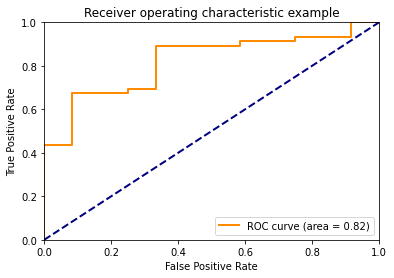

In [50]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_score(test_y, y_test_pred_proba[:,1]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [42]:
fpr

array([0.        , 0.        , 0.        , 0.08333333, 0.08333333,
       0.25      , 0.25      , 0.33333333, 0.33333333, 0.58333333,
       0.58333333, 0.75      , 0.75      , 0.91666667, 0.91666667,
       1.        ])

### Econometrics - logistic regression

In [19]:
df = df.drop(['PrimaryStudy_to_Synopsis','0','numValsLSO','numValsDBL', 'Unlocks'], axis = 1)

In [21]:
import statsmodels.api as sm

train_X, eval_X, trval_X, test_X, train_y, eval_y, trval_y, test_y = binary_classification.split_data(df, 
                                                                                DATE_BOUND_TRAIN = DATE_BOUND_TRAIN, 
                                                                                DATE_BOUND_EVAL = DATE_BOUND_EVAL,
                                                                                DATE_BOUND_TEST = DATE_BOUND_TEST)

trval_X = trval_X.fillna(trval_X.median())

logit_model=sm.Logit(trval_y, trval_X)
result=logit_model.fit_regularized(method = 'l1', alpha = 9.233859476879779)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5613420926743788
            Iterations: 30
            Function evaluations: 75
            Gradient evaluations: 30


C:\Users\wyk7050\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\wyk7050\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [22]:
print(result.summary2())

                            Results: Logit
Model:                Logit              Pseudo R-squared:   0.130     
Dependent Variable:   Ontime             AIC:                309.7114  
Date:                 2021-08-11 21:05   BIC:                355.7478  
No. Observations:     255                Log-Likelihood:     -141.86   
Df Model:             12                 LL-Null:            -163.00   
Df Residuals:         242                LLR p-value:        2.9884e-05
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       30.0000                                          
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
PlannedEnrollment       -0.0036   0.0015 -2.3629 0.0181 -0.0065 -0.0006
ActualEnrollment         0.0010   0.0017  0.5876 0.5568 -0.0023  0.0044
ActualRandomizedDosed

In [110]:
trval_X.isna().sum()

PlannedEnrollment          0
ActualEnrollment           0
ActualRandomizedDosed      0
ActualEarlyTerminated      0
PercEnrollmentCompleted    0
PlannedSites               0
ActiveSites                0
Synopsis_to_Protocol       0
FSS_to_FSI                 0
LSI_to_LSO                 0
AE                         0
CM                         0
DS                         0
DV                         0
EG                         0
EX                         0
FA                         0
LB                         0
MH                         0
PR                         0
SS                         0
VS                         0
Lock_duration              0
Expected_CloseOut          0
Unlocks                    0
PercActualCompetedTrial    0
Celerion                   0
IQVIA                      0
Other                      0
PPD                        0
PRA                        0
I                          0
II                         0
III                        0
IV            

<AxesSubplot:>

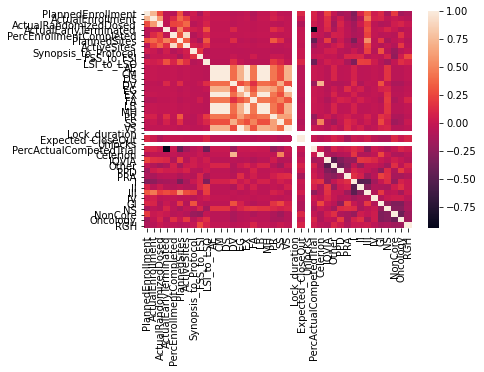

In [111]:
import seaborn as sns
corr = train_X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [117]:
train_X.Lock_duration

0      0.0
3      0.0
6      0.0
7      0.0
9      0.0
      ... 
307    0.0
308    0.0
309    0.0
310    0.0
311    0.0
Name: Lock_duration, Length: 182, dtype: float64